In [21]:
import pandas as pd
from matplotlib import pyplot as plt
import keras
from keras import layers
from keras import models
import numpy as np
from matplotlib.ticker import ScalarFormatter
import tensorflow as tf
import pydot

In [22]:
#Training Data取得

train_d = []
for i in range(200,300):
    d = np.loadtxt(rf"Z:\200 実験データ加工\20220630\TrainingData\FFT_Norm\csv\FFT_Norm_{i}.csv", delimiter=',')
    train_d.append(d)

train_d = np.array(train_d)

In [23]:
#Test Data取得

#test_d1 : 2021年11月15日
test_d1 = []

#test_d2：2022年6月30日
test_d2 = []

for i in range(1,242):
    d = np.loadtxt(rf"Z:\200 実験データ加工\20211115---切削実験---AE+切削抵抗\TrainingData\FFT_Norm\csv\FFT_Norm_{i}.csv")
    test_d1.append(d)
test_d1 = np.array(test_d1)

for i in range(1,737):
    d = np.loadtxt(rf"Z:\200 実験データ加工\20220630\TrainingData\FFT_Norm\csv\FFT_Norm_{i}.csv", delimiter=',')
    test_d2.append(d)
test_d2 = np.array(test_d2)

In [24]:
print(train_d.shape)
print(test_d1.shape)
print(test_d2.shape)

(100, 820)
(241, 820)
(736, 820)


In [25]:
encoding_dim = 30
model = models.Sequential()
model.add(layers.Dense(encoding_dim, activation='relu',
                       input_shape=(train_d.shape[1],)))
model.add(layers.Dense(train_d.shape[1],
                       activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 30)                24630     
                                                                 
 dense_9 (Dense)             (None, 820)               25420     
                                                                 
Total params: 50,050
Trainable params: 50,050
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(
    train_d,
    train_d,
    epochs=200,
    batch_size=100,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/200
1/1 [==============================] - 0s 458ms/step - loss: 0.1295 - val_loss: 0.1120
Epoch 2/200
1/1 [==============================] - 0s 50ms/step - loss: 0.1284 - val_loss: 0.1110
Epoch 3/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1274 - val_loss: 0.1098
Epoch 4/200
1/1 [==============================] - 0s 42ms/step - loss: 0.1261 - val_loss: 0.1082
Epoch 5/200
1/1 [==============================] - 0s 42ms/step - loss: 0.1244 - val_loss: 0.1062
Epoch 6/200
1/1 [==============================] - 0s 39ms/step - loss: 0.1224 - val_loss: 0.1036
Epoch 7/200
1/1 [==============================] - 0s 46ms/step - loss: 0.1198 - val_loss: 0.1007
Epoch 8/200
1/1 [==============================] - 0s 43ms/step - loss: 0.1168 - val_loss: 0.0972
Epoch 9/200
1/1 [==============================] - 0s 40ms/step - loss: 0.1133 - val_loss: 0.0934
Epoch 10/200
1/1 [==============================] - 0s 40ms/step - loss: 0.1094 - val_loss: 0.0891
Epoch 11/200
1/1 [

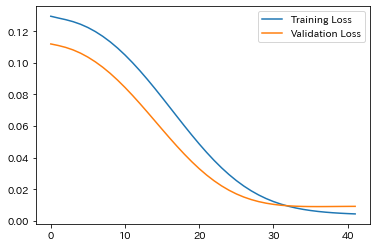

In [27]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [28]:
#predict
train_d_pred = model.predict(train_d)

#reshape(100,820,1) -> (100,820)
train_d_pred = train_d_pred.reshape(100,820)

#再構成誤差計算
train_mae_loss = np.mean(np.square(np.abs(train_d_pred - train_d)), axis=1)


#再構成誤差の平均値
train_mae_loss_mean = np.mean(train_mae_loss)

#再構成誤差の標準偏差
train_mae_loss_std = np.std(train_mae_loss)

#閾値設定
#閾値T = μ+3σ (μ:train_dの再構成誤差の平均値、σ:train_dの再構成誤差のの標準偏差)

threshold = train_mae_loss_mean + train_mae_loss_std * 3

4/4 [==============================] - 0s 3ms/step


In [30]:
print(train_mae_loss_mean)
print(train_mae_loss_std)
print(threshold)

0.004714211120973968
0.002775901459638671
0.013041915499889981


In [44]:
# test1 predict & reshape & get reconstruction error
test1_pred = model.predict(test_d1)
test1_pred = test1_pred.reshape(241,820)
test1_mae_loss = np.mean(np.square(np.abs(test1_pred - test_d1)), axis=1)

#再構成誤差の平均値
test1_mae_loss_mean = np.mean(test1_mae_loss)

#再構成誤差の標準偏差
test1_mae_loss_std = np.std(test1_mae_loss)

#閾値T = μ+3σ (μ:train_dの再構成誤差の平均値、σ:2021年11月全データ（1~241path）の再構成誤差のの標準偏差)
threshold2 = train_mae_loss_mean + test1_mae_loss_std * 3


#-----------------------------------------------------------------------------------------



# test2 predict & reshape & get reconstruction error
test2_pred = model.predict(test_d2)
test2_pred = test2_pred.reshape(736,820)
test2_mae_loss = np.mean(np.square(np.abs(test2_pred - test_d2)), axis=1)


#再構成誤差の平均値
test2_mae_loss_mean = np.mean(test2_mae_loss)

#再構成誤差の標準偏差
test2_mae_loss_std = np.std(test2_mae_loss)

#閾値T = μ+3σ (μ:train_dの再構成誤差の平均値、σ:2022年6月全データ（1~736path）の再構成誤差のの標準偏差)
threshold3 = train_mae_loss_mean + test2_mae_loss_std * 3

23/23 [==============================] - 0s 2ms/step


In [32]:
#RE は　Reconstruction Errorの略
test1_RE = test1_mae_loss.reshape(-1)
test2_RE = test2_mae_loss.reshape(-1)

print(test1_RE.shape)
print(test2_RE.shape)

(241,)
(736,)


In [33]:
distance1 = 49*241/1000
distance2 = 49*736/1000
test1_distance = np.linspace(0,distance1,241)
test2_distance = np.linspace(0,distance2,736)

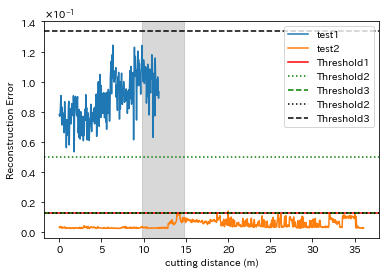

In [45]:
fig, ax = plt.subplots()

ax.set_xlabel("cutting distance (m)")
ax.set_ylabel("Reconstruction Error")
ax.axvspan(test2_distance[200], test2_distance[300], color="gray", alpha=0.3)

plt.plot(test1_distance, test1_RE, label="test1")
plt.plot(test2_distance, test2_RE, label="test2")

plt.axhline(y = threshold, color='red', linestyle = '-', label="Threshold1")
plt.axhline(y = threshold2, color='green', linestyle = 'dotted', label="Threshold2")
plt.axhline(y = threshold3, color='green', linestyle = 'dashed', label="Threshold3")
# plt.axhline(y = threshold4, color='black', linestyle = 'dotted', label="Threshold2")
# plt.axhline(y = threshold5, color='black', linestyle = 'dashed', label="Threshold3")

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))


plt.legend()
# plt.savefig("RE_test2_simple_model.png", dpi=300)
plt.show()

In [35]:
#モデル保存
model.save("nn_simple.h5")  # .h5 = HDF5

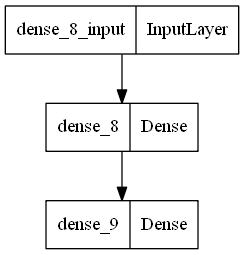

In [40]:
#モデルの可視化
from keras.utils import plot_model
plot_model(model, to_file='modelsimple_with_shape.png', show_shapes=True)
plot_model(model, to_file='modelsimple_without_shape.png', show_shapes=False)

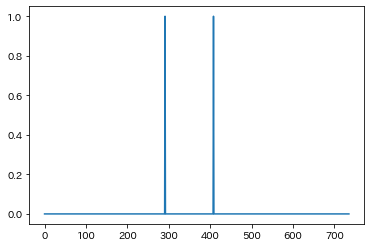

In [36]:
anomalies2 = test2_RE > threshold
plt.plot(anomalies2)

In [37]:
ind = np.where(anomalies2 == 1)
ind

(array([291, 408], dtype=int64),)